In [1]:
import pandas as pd
import os
import opendatasets as od
from tqdm import tqdm
from pathlib import Path
import shutil
import random
from coulumb_utils.xyz import read_xyz, parse_xyz_file, create_dataframe_from_xyz
from coulumb_utils.calculate_coulumb_matrix import calculate_coulomb_matrix
from coulumb_utils.sort_molecules import sort_by_atomic_number, sort_by_row_norm
from coulumb_utils.normalize import normalize_min_max, log_normalize
from coulumb_utils.eigen_padd import compute_eigenvalues, padd_eig, padd_matrix
from coulumb_utils.standardize import standardize_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.linear_model import Ridge
from xgboost import plot_importance

# Download dataset

The dataset is on Kaggle - https://www.kaggle.com/datasets/mariovozza5/qm9-molecules

In [10]:

dataset = "https://www.kaggle.com/datasets/mariovozza5/qm9-molecules"

if not os.path.exists("qm9-molecules"): od.download(dataset)

Dataset URL: https://www.kaggle.com/datasets/mariovozza5/qm9-molecules


100%|██████████| 130M/130M [00:17<00:00, 7.87MB/s] 


# Load xyz files

In [2]:
work_path = Path("./qm9-molecules/")
data_path = work_path.joinpath("data")

subset_size = 1000

df = create_dataframe_from_xyz(data_path, subset_size)
df_sorted = df.sort_values('index', ascending=True)

df_sorted.head(10)

100%|██████████| 1000/1000 [00:00<00:00, 32804.91it/s]


,filename,n_atoms,index,A,B,C,mu,alpha,homo,lumo,gap,R2,zpve,U0,U,H,G,Cv
579,qm9_272,18,272,6.81970,1.72205,1.47522,1.3839,60.25,-0.2613,0.0807,0.3420,850.8528,0.164714,-272.837559,-272.829406,-272.828462,-272.869568,28.734
835,qm9_637,16,637,6.01713,2.59419,2.00512,1.5102,56.58,-0.2585,0.0791,0.3376,658.5353,0.142089,-271.619912,-271.612845,-271.611901,-271.650485,25.760
211,qm9_1014,9,1014,9.83231,2.03584,1.68662,2.7733,52.24,-0.2763,-0.0623,0.2140,648.9718,0.057354,-338.273162,-338.268017,-338.267072,-338.302227,17.914
700,qm9_1017,12,1017,9.08760,1.91529,1.58189,2.8340,65.16,-0.2054,0.0167,0.2222,727.2033,0.091471,-286.246880,-286.240878,-286.239934,-286.276357,23.043
429,qm9_1067,14,1067,7.43399,1.95952,1.57102,1.7350,59.38,-0.1898,0.0312,0.2210,760.6560,0.114923,-324.589539,-324.583091,-324.582147,-324.619783,23.926
924,qm9_1100,17,1100,3.27780,2.35057,1.96982,2.5591,60.44,-0.2405,-0.0104,0.2301,764.3556,0.144105,-346.883049,-346.874108,-346.873164,-346.916540,31.978
581,qm9_1132,21,1132,4.06437,1.54353,1.36761,1.0249,71.72,-0.2419,0.0805,0.3224,1021.1314,0.191749,-312.131398,-312.121927,-312.120983,-312.165172,34.217
313,qm9_1303,16,1303,3.46915,2.57533,2.20806,2.4567,61.50,-0.2609,0.0323,0.2932,703.5227,0.136267,-325.785262,-325.777909,-325.776964,-325.816273,27.018
722,qm9_1314,17,1314,3.23345,2.60446,2.10715,1.0048,60.09,-0.2515,0.0751,0.3266,720.2405,0.146617,-346.844016,-346.836105,-346.835161,-346.875318,29.716
57,qm9_1341,19,1341,4.90250,1.71312,1.55301,0.9650,68.75,-0.2406,0.0932,0.3339,897.6244,0.169391,-310.901659,-310.893126,-310.892182,-310.933912,31.118


# Data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1000 non-null   object 
 1   n_atoms   1000 non-null   int64  
 2   index     1000 non-null   int64  
 3   A         1000 non-null   float64
 4   B         1000 non-null   float64
 5   C         1000 non-null   float64
 6   mu        1000 non-null   float64
 7   alpha     1000 non-null   float64
 8   homo      1000 non-null   float64
 9   lumo      1000 non-null   float64
 10  gap       1000 non-null   float64
 11  R2        1000 non-null   float64
 12  zpve      1000 non-null   float64
 13  U0        1000 non-null   float64
 14  U         1000 non-null   float64
 15  H         1000 non-null   float64
 16  G         1000 non-null   float64
 17  Cv        1000 non-null   float64
dtypes: float64(15), int64(2), object(1)
memory usage: 140.8+ KB


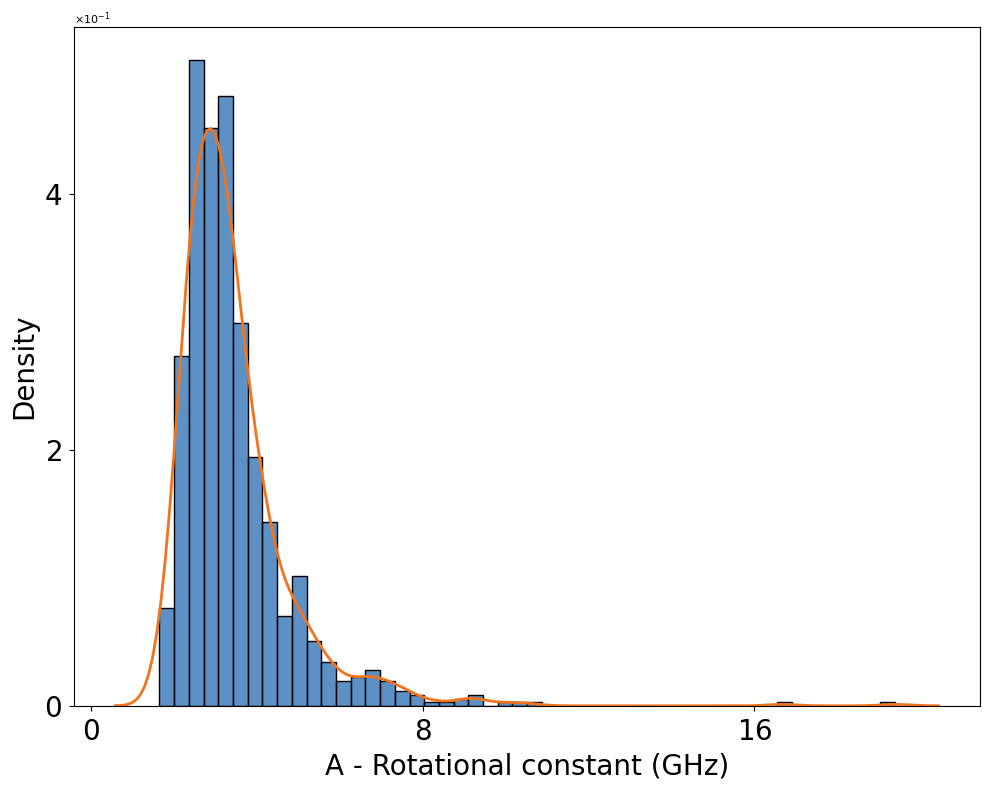

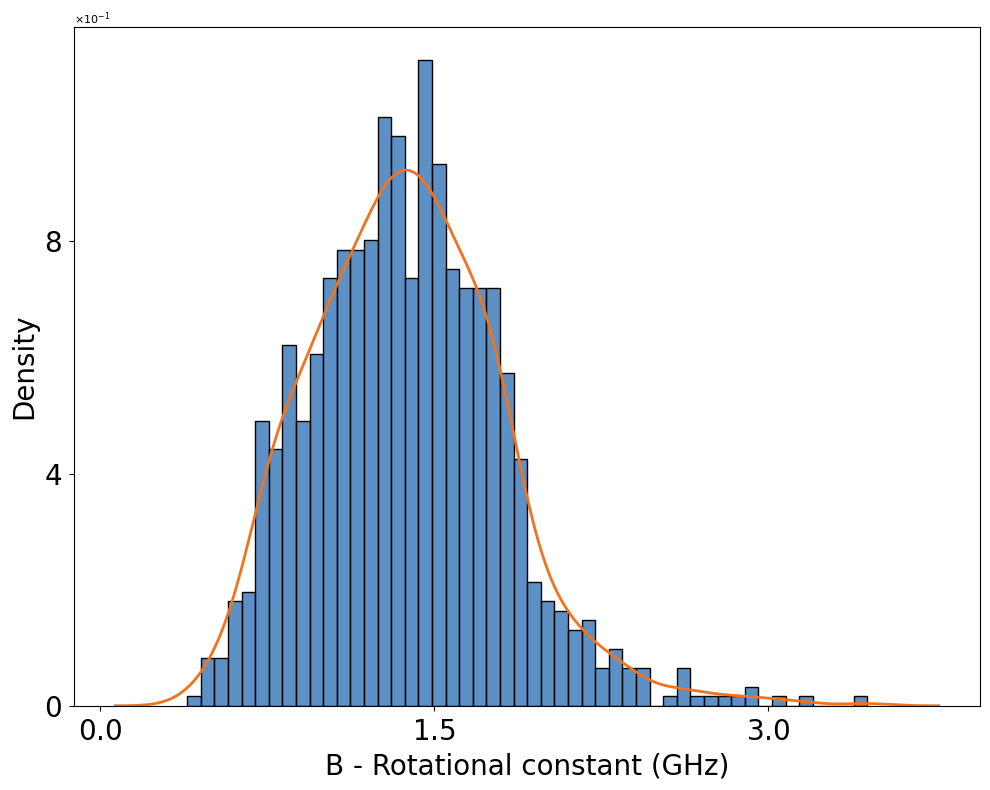

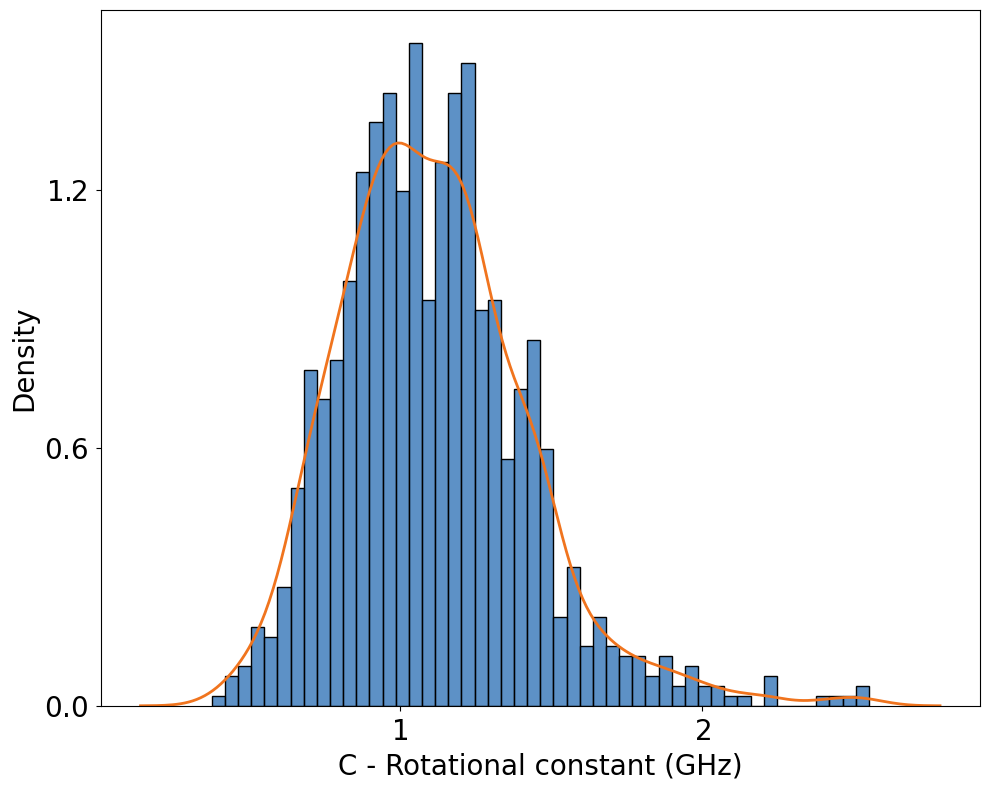

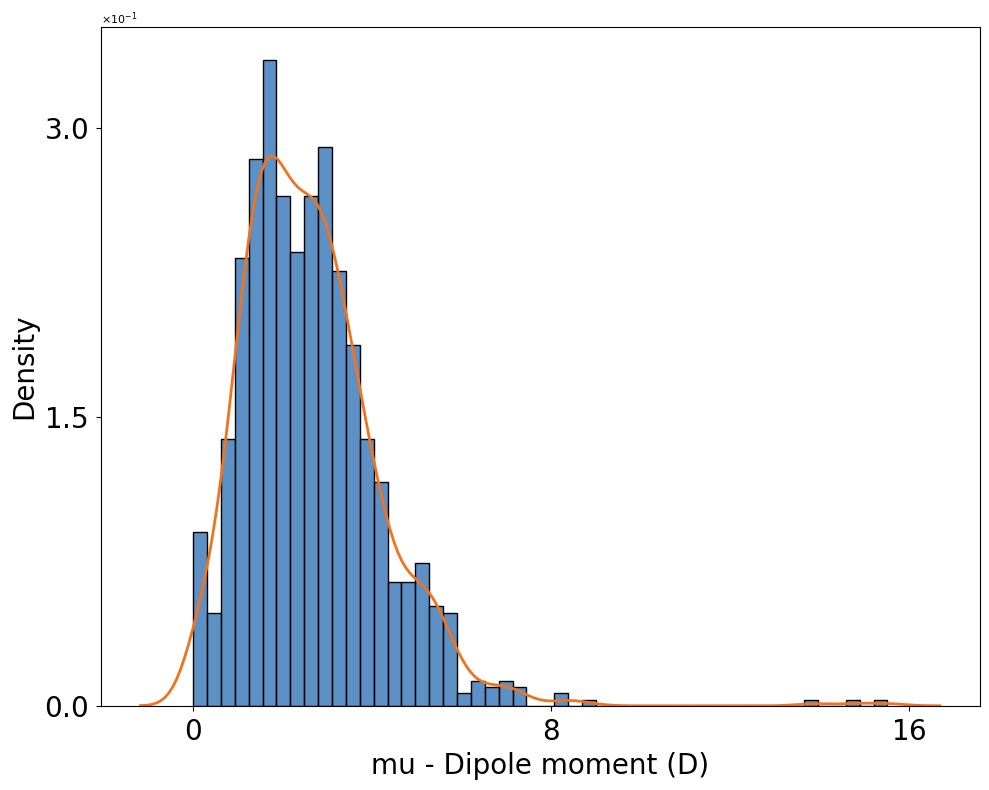

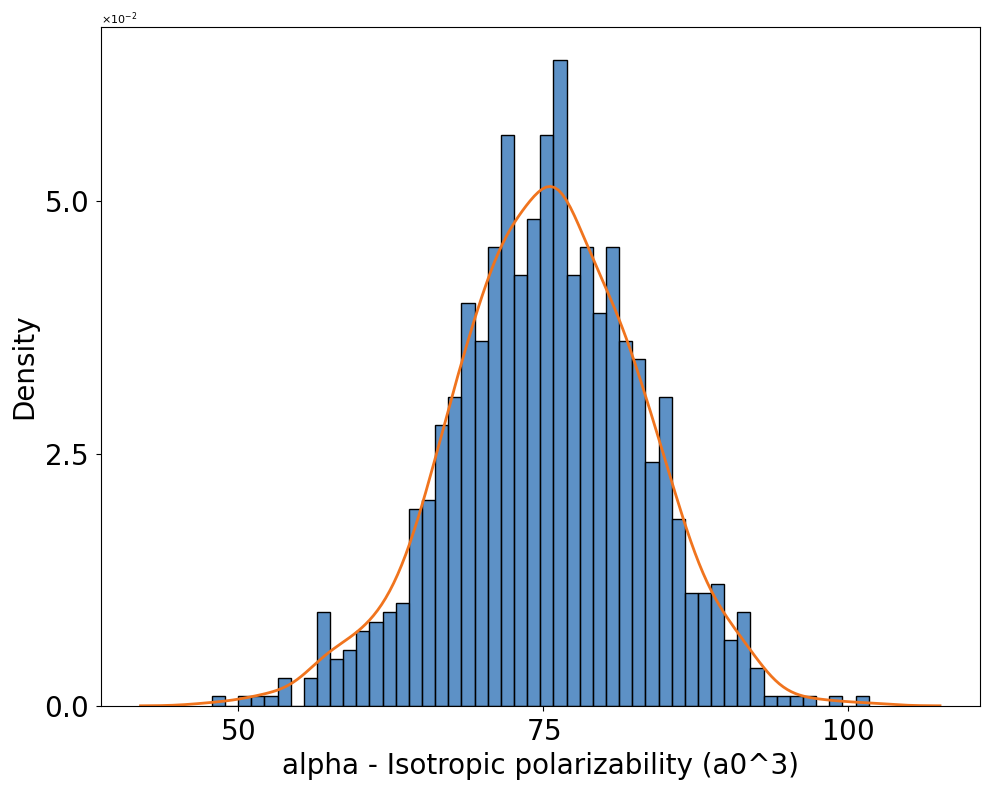

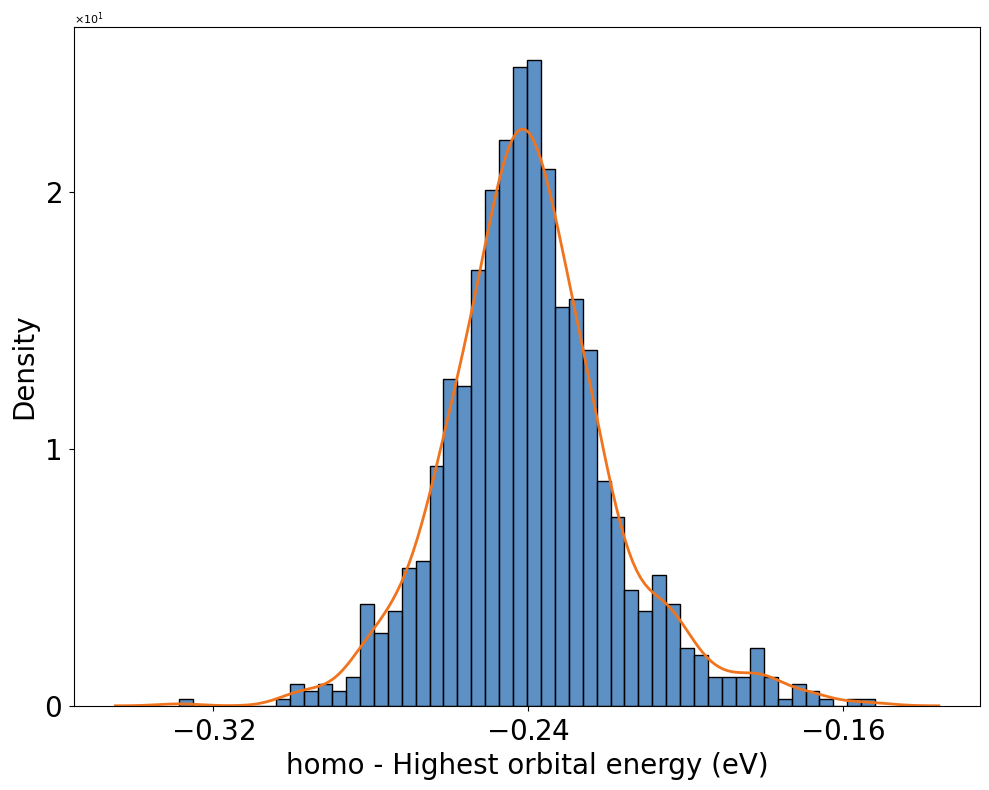

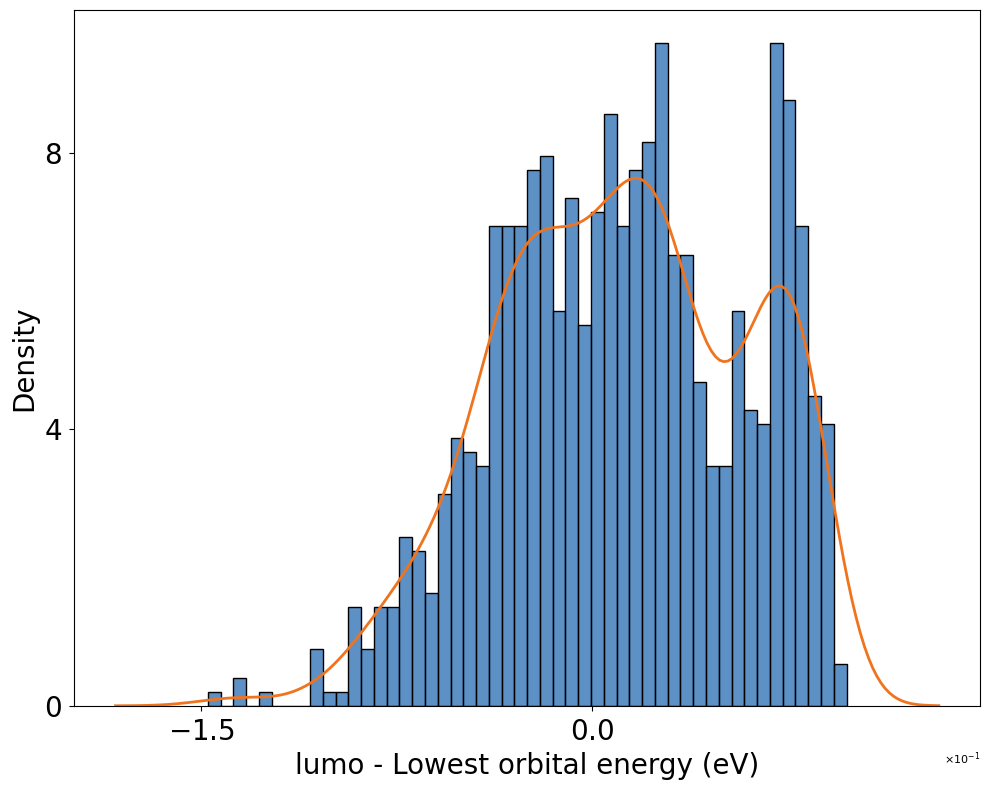

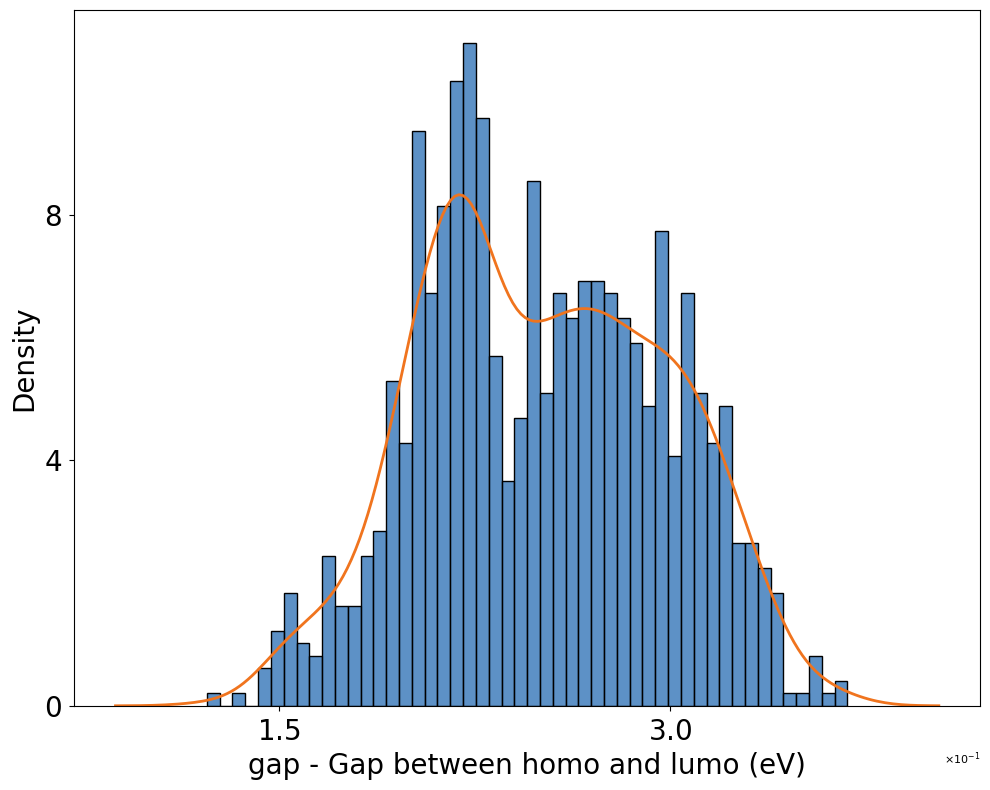

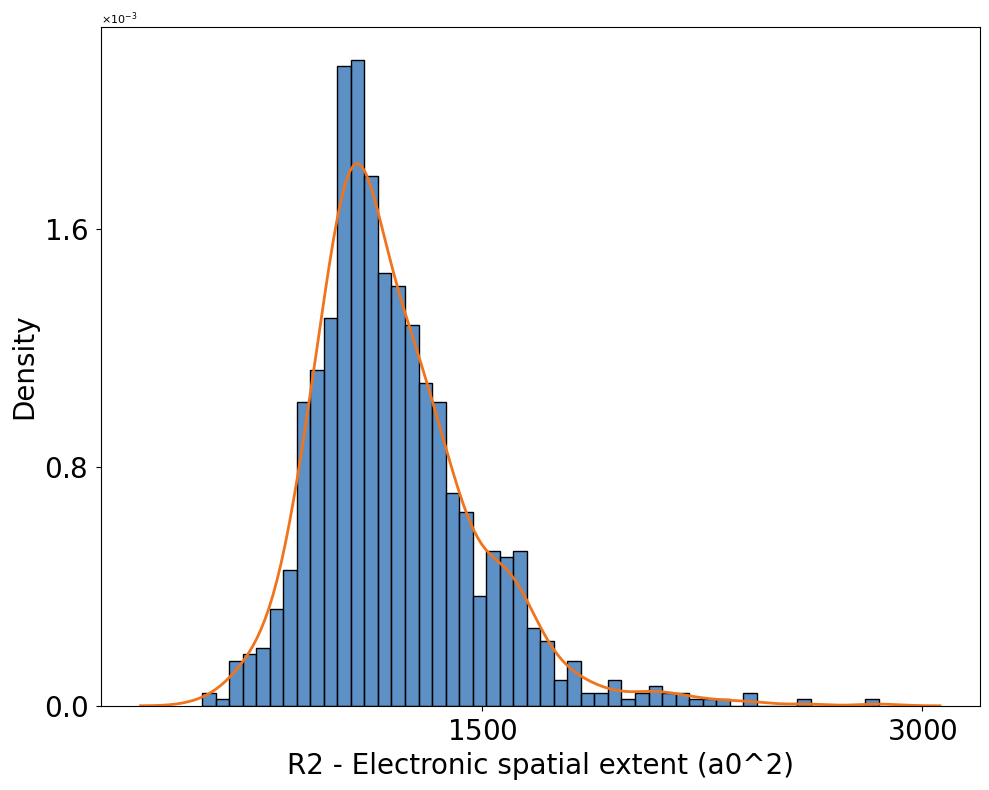

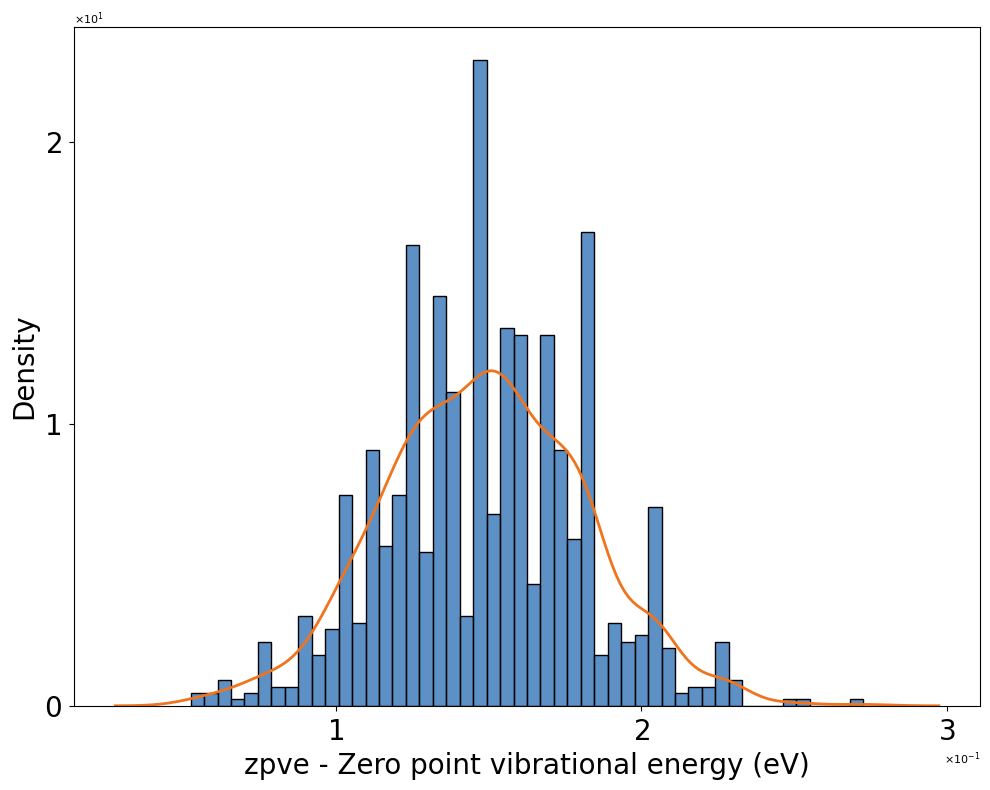

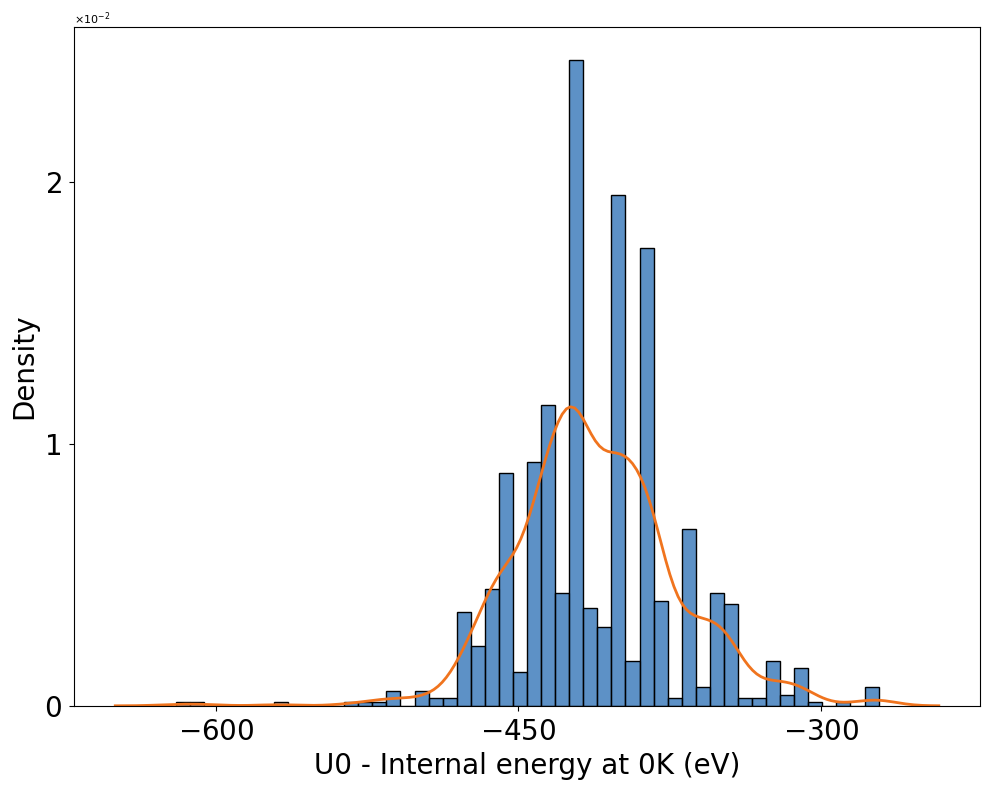

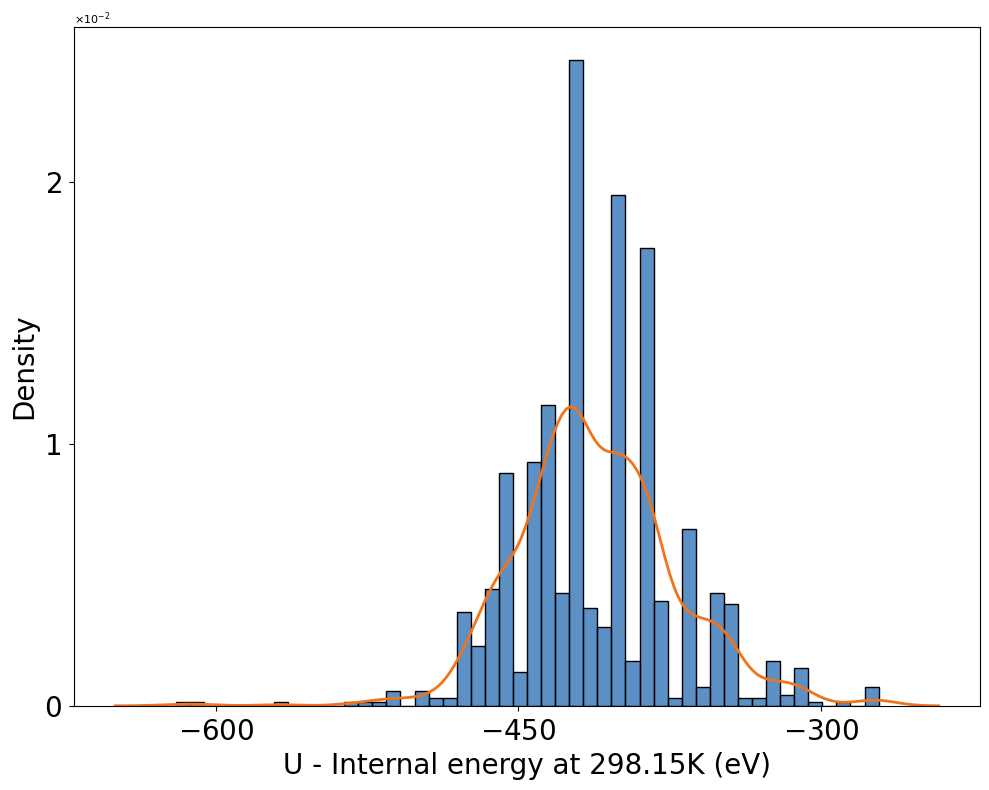

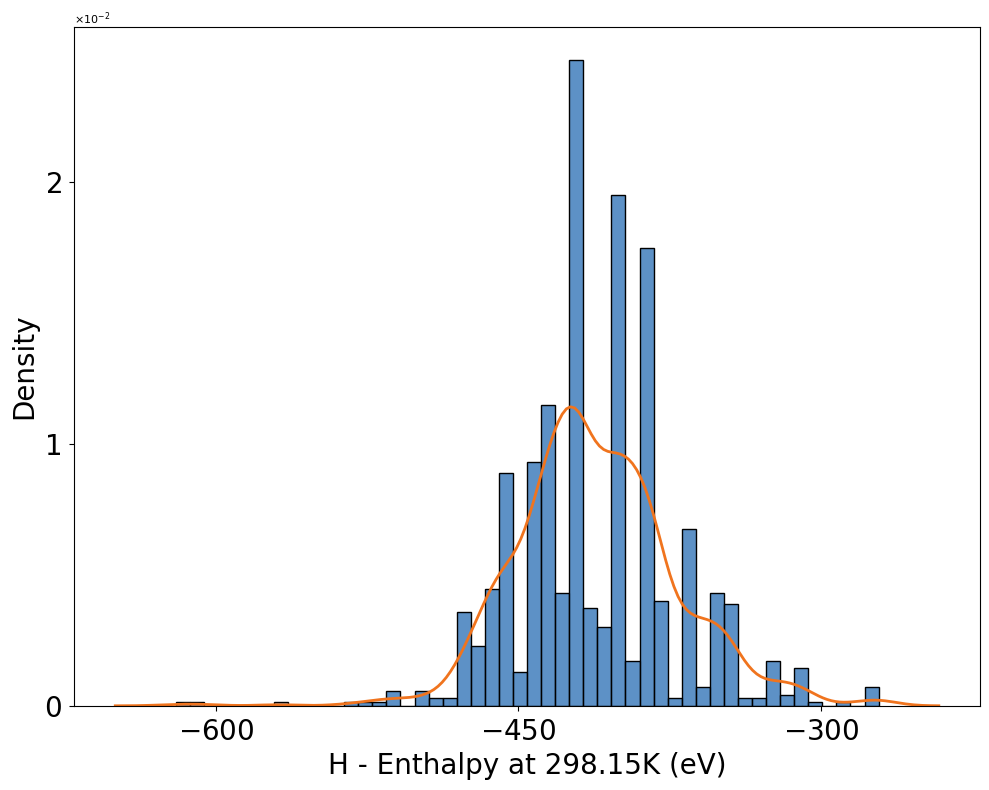

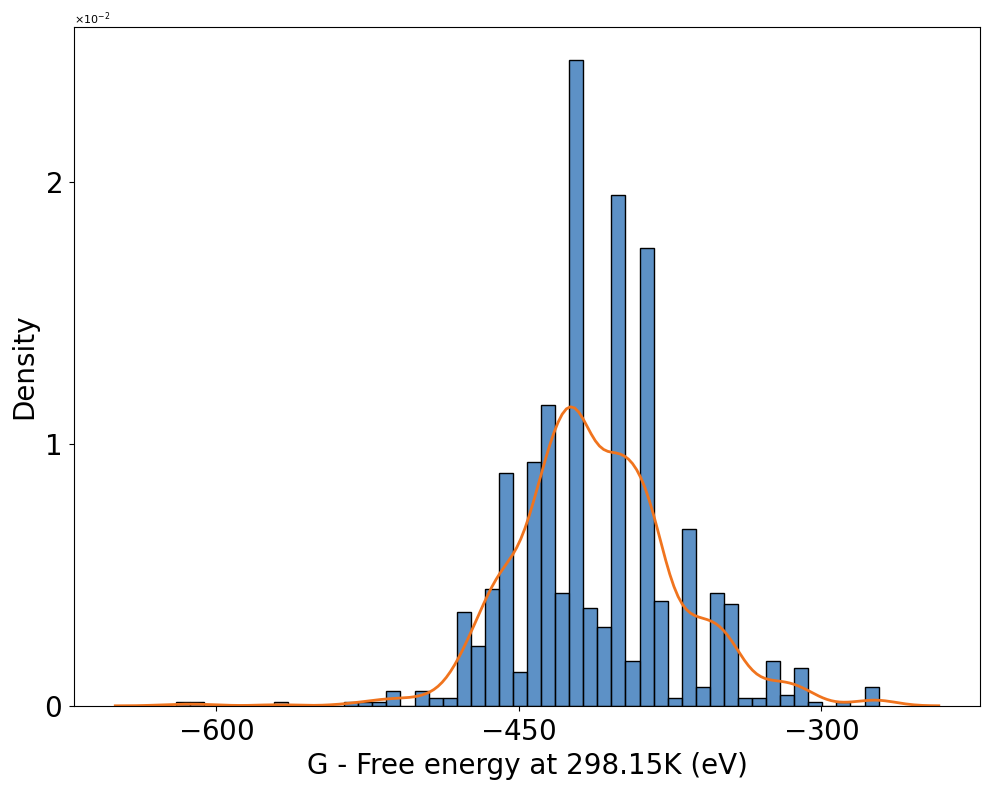

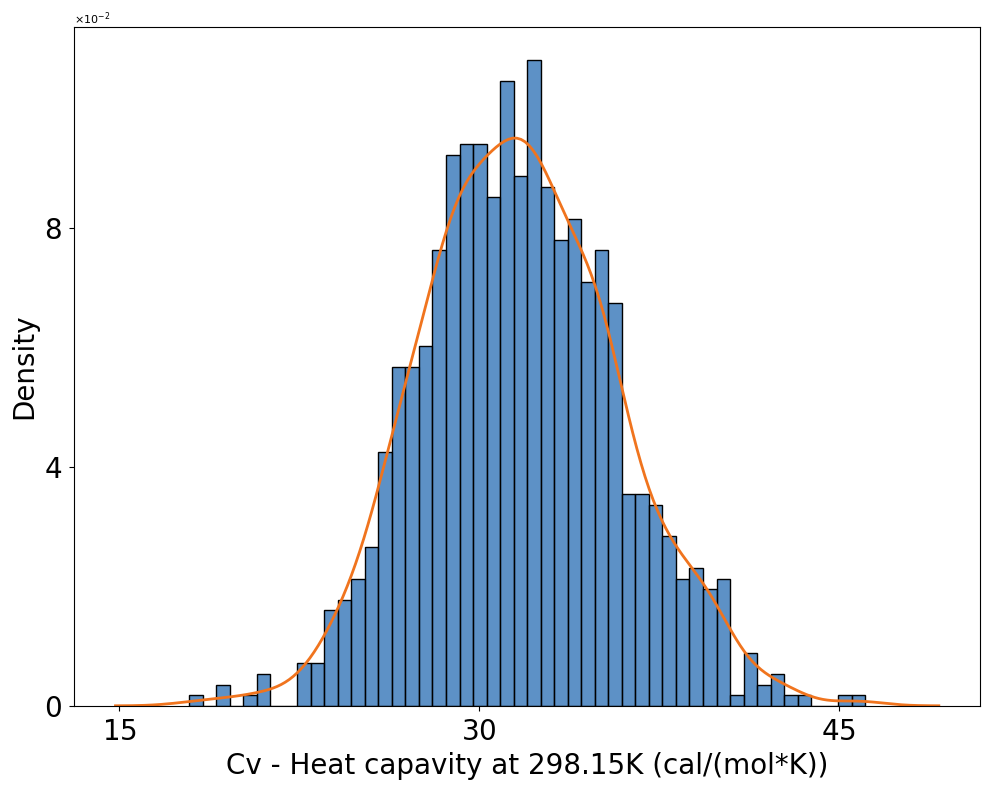

In [4]:
colors = ["#F0741E", "#276CB3"]
plt.style.use("seaborn-v0_8-paper")

target_list = ["A","B",	"C",	"mu",	"alpha",	"homo",	"lumo",	"gap",	"R2",	"zpve",	"U0",	"U",	"H",	"G",	"Cv"]
#dictionry of the x and y labels for plot
target_labels = {
    "A": ("A - Rotational constant (GHz)", "Density"),
    "B": ("B - Rotational constant (GHz)", "Density"),
    "C": (
        "C - Rotational constant (GHz)",
        "Density",
    ),
    "mu": (
        "mu - Dipole moment (D)",
        "Density",
    ),
    "alpha": (
        "alpha - Isotropic polarizability (a0^3)",
        "Density",
    ),
    "homo": (
        "homo - Highest orbital energy (eV)",
        "Density",
    ),
    "lumo": (
        "lumo - Lowest orbital energy (eV)",
        "Density",
    ),
    "gap": (
        "gap - Gap between homo and lumo (eV)",
        "Density",
    ),
    "R2": (
        "R2 - Electronic spatial extent (a0^2)",
        "Density",
    ),
    "zpve": (
        "zpve - Zero point vibrational energy (eV)",
        "Density",
    ),
    "U0": (
        "U0 - Internal energy at 0K (eV)",
        "Density",
    ),
    "U": (
        "U - Internal energy at 298.15K (eV)",
        "Density",
    ),
    "H": (
        "H - Enthalpy at 298.15K (eV)",
        "Density",
    ),
    "G": (
        "G - Free energy at 298.15K (eV)",
        "Density",
    ),
    "Cv": (
        "Cv - Heat capavity at 298.15K (cal/(mol*K))",
        "Density",
    ),
}

# histogram and the kde
for target in target_list:

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(1, 1, 1)

    sns.histplot(
        x=df_sorted[f"{target}"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=50,
    )

    sns.kdeplot(x=df_sorted[f"{target}"], linewidth=2, color=colors[0], ax=ax)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.show()
